# Introduction

This notebook compares a predictive regression with a neural network. 
The data comes from the paper "Do Industries Lead Stock Markets?" by Valkanov et al., accesible here: https://rady.ucsd.edu/people/faculty/valkanov/

Some highlights: 
* IR (information ratio = alpha/stdev(alpha)) from regression with no lags: 1.20
* IR from LSTM network with 1-time step depth (1-step is equivalent to no lags): 1.24
* The regression baseline has highly correlated regressors. L2 regularization (ridge regression) helps. 
* LSTM network has only 1-step depth. Next step is to add several more steps. 
* Using a neural network will not provide improved prediction, if the linear approach already harvested the information in the predictors. 
* In both cases, the strategy would not work in recent years, corresponding to markets becoming more and more efficient. 


# The Regression Baseline

In [3]:
# Read the data in. 
import numpy as np
import pandas as pd
dataPath = '/Users/marius/Documents/DeepLearning/data/'
# careful on reading industry returns: 
# The top of the file has the value weighted returns, bottom has equally weighted. We read value-weighted. 
# Also, we need to skip several lines of comments in the begining. 
indu_raw_vw_df = pd.read_csv(dataPath + '12_Industry_Portfolios_Daily.CSV', skiprows = 2, header = 3, nrows=24431)
mrkt_raw_df = pd.read_csv(dataPath + 'sp500.csv')

# Make sure the date columns are not just strings
indu_raw_vw_df['Date'] = pd.to_datetime(indu_raw_vw_df['Date'], format='%Y%m%d') 
mrkt_raw_df['Date'] = pd.to_datetime(mrkt_raw_df['Date'])


In [4]:
print(indu_raw_vw_df.head(2))
print('~'*20)
print(indu_raw_vw_df.tail(2))
print('~'*20)
print(indu_raw_vw_df.dtypes)

        Date  NoDur  Durbl  Manuf  Enrgy  Chems  BusEq  Telcm  Utils  Shops  \
0 1926-07-01   0.02  -0.28  -0.41   0.57   0.52  -0.25  -0.02   0.61  -0.01   
1 1926-07-02   0.29   1.07   0.83   0.64   0.97   0.13   0.26   0.47   0.01   

   Hlth  Money  Other  
0  0.97   0.60   0.20  
1  0.13  -0.02   0.11  
~~~~~~~~~~~~~~~~~~~~
            Date  NoDur  Durbl  Manuf  Enrgy  Chems  BusEq  Telcm  Utils  \
24429 2019-02-27   0.25   0.68   0.37   0.48  -0.16   0.12  -0.31   0.16   
24430 2019-02-28   0.61  -0.26  -0.48  -1.01  -0.81  -0.45   0.26   0.22   

       Shops  Hlth  Money  Other  
24429  -0.06  0.26  -0.09  -0.06  
24430   0.05  0.01  -0.35  -0.62  
~~~~~~~~~~~~~~~~~~~~
Date     datetime64[ns]
NoDur           float64
Durbl           float64
Manuf           float64
Enrgy           float64
Chems           float64
BusEq           float64
Telcm           float64
Utils           float64
Shops           float64
Hlth            float64
Money           float64
Other           float64
dt

In [5]:
print(mrkt_raw_df.head(2))
print('~'*20)
print(mrkt_raw_df.dtypes)

        Date   Open   High    Low  Close  Adj Close   Volume
0 1950-01-03  16.66  16.66  16.66  16.66      16.66  1260000
1 1950-01-04  16.85  16.85  16.85  16.85      16.85  1890000
~~~~~~~~~~~~~~~~~~~~
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object


In [6]:
# The sp500 data is price levels, not returns. Get returns.
mrkt_raw_df = mrkt_raw_df[['Date', 'Adj Close']]
mrkt_raw_df['Adj Close'] = mrkt_raw_df['Adj Close'].pct_change()
mrkt_raw_df.head(3)


,Date,Adj Close
0,1950-01-03,NaN
1,1950-01-04,0.011405
2,1950-01-05,0.004748


In [7]:
# Lag the industry returns one-period for predictive regression
indu_lagged = indu_raw_vw_df
indu_lagged.set_index('Date', inplace=True)
indu_lagged = indu_lagged.shift(periods=1)
indu_lagged.reset_index(level='Date')

,Date,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other
0,1926-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1926-07-02,0.02,-0.28,-0.41,0.57,0.52,-0.25,-0.02,0.61,-0.01,0.97,0.60,0.20
2,1926-07-06,0.29,1.07,0.83,0.64,0.97,0.13,0.26,0.47,0.01,0.13,-0.02,0.11
3,1926-07-07,0.24,0.72,0.24,0.17,0.23,0.44,0.17,0.73,-0.23,0.23,0.08,-0.20
4,1926-07-08,0.27,0.06,0.05,-0.04,0.73,-0.01,0.32,0.17,-0.58,0.33,-0.18,0.17
5,1926-07-09,0.69,0.05,0.23,0.12,-0.09,0.36,0.40,-0.20,-0.36,0.91,-0.42,0.42
6,1926-07-10,-0.39,-1.15,-0.93,-1.60,-1.57,-0.83,0.21,-0.74,0.40,-0.28,0.04,-0.26
7,1926-07-12,0.67,1.23,0.75,0.65,0.63,0.50,0.07,0.55,0.52,-0.17,0.33,0.57
8,1926-07-13,0.27,0.78,0.19,-1.27,0.44,0.03,0.15,0.23,0.27,0.22,-0.54,0.41
9,1926-07-14,-0.46,1.92,0.64,0.37,1.14,1.76,0.03,0.20,0.32,0.57,0.89,0.25


In [8]:
def my_add_const(pred):
    pred_num_rows = pred.shape[0]
    pred_c = pd.DataFrame()
    pred_c['const'] = pd.Series(np.ones(pred_num_rows), index=pred.index)
    pred_c = pd.concat([pred_c, pred], axis=1)
    return(pred_c)

In [27]:
# feature analysis is needed. E.g. dropping 'Other' (highly correlated) improved the IR by 0.04 
# When adding L2 regularization (coeff = 0.1), there is no improvement to dropping 'Other'
#all_data = all_data.drop(['Other'], axis=1) 

In [19]:
import statsmodels.api as sm
# Join the two data frames. 
all_data = pd.merge(indu_lagged, mrkt_raw_df, how='inner', on='Date')
all_data.dropna(inplace=True)
date_line = all_data['Date']

# Split the X, y. Use 10-year chunks.
firstDate  = pd.to_datetime('1960-01-04')
lastDate   = pd.to_datetime('2018-01-01')
strategy_date_line = date_line[(date_line >= firstDate) & (date_line <= lastDate)]
strategy_date_line = np.array(strategy_date_line)

# Our strategy: go long if predicted return is positive, go short otherwise
stra_data = {'ret': np.zeros(len(strategy_date_line))}
stra_df = pd.DataFrame(data=stra_data, index=strategy_date_line)
prior_weight = 0 # remember prior weight
for end_date in strategy_date_line:
    print(end_date)
    start_date = end_date - np.timedelta64(365*10,'D')
    xx = all_data[(all_data.Date >= start_date) & (all_data.Date < end_date)] 
    yy = xx[['Adj Close']]
    xx = xx.drop(['Date', 'Adj Close'], axis=1) 
    xx_const = sm.add_constant(xx)
    model = sm.OLS(yy, xx_const)
    # Because of high correlations, let's regularize with L2 norm (ridge regression)
    #results = model.fit() # IR = 1.11 without regularization
    results = model.fit_regularized(alpha=0.1, L1_wt = 0) # ridge regression (only L2 penalty) IR = 1.20
    xpred = all_data[all_data.Date == end_date]
    y = xpred['Adj Close'].values[0] # actual return
    xpred = xpred.drop(['Date', 'Adj Close'], axis = 1)
    xpred_const = my_add_const(xpred)
    yhat = results.predict(xpred_const) # predicted return from model
    yhat = yhat.values[0]
    if np.abs(yhat) < 1e-4: # do not trade if prediction is close to zero
        weight = prior_weight # this avoids turnover, trading costs
    else:
        weight = np.sign(yhat)
    stra_df.loc[end_date] = weight * y # weight * actual return
    prior_weight = weight


1960-01-04T00:00:00.000000000
1960-01-05T00:00:00.000000000
1960-01-06T00:00:00.000000000
1960-01-07T00:00:00.000000000
1960-01-08T00:00:00.000000000
1960-01-11T00:00:00.000000000
1960-01-12T00:00:00.000000000
1960-01-13T00:00:00.000000000
1960-01-14T00:00:00.000000000
1960-01-15T00:00:00.000000000
1960-01-18T00:00:00.000000000
1960-01-19T00:00:00.000000000
1960-01-20T00:00:00.000000000
1960-01-21T00:00:00.000000000
1960-01-22T00:00:00.000000000
1960-01-25T00:00:00.000000000
1960-01-26T00:00:00.000000000
1960-01-27T00:00:00.000000000
1960-01-28T00:00:00.000000000
1960-01-29T00:00:00.000000000
1960-02-01T00:00:00.000000000
1960-02-02T00:00:00.000000000
1960-02-03T00:00:00.000000000
1960-02-04T00:00:00.000000000
1960-02-05T00:00:00.000000000
1960-02-08T00:00:00.000000000
1960-02-09T00:00:00.000000000
1960-02-10T00:00:00.000000000
1960-02-11T00:00:00.000000000
1960-02-12T00:00:00.000000000
1960-02-15T00:00:00.000000000
1960-02-16T00:00:00.000000000
1960-02-17T00:00:00.000000000
1960-02-18

1961-02-07T00:00:00.000000000
1961-02-08T00:00:00.000000000
1961-02-09T00:00:00.000000000
1961-02-10T00:00:00.000000000
1961-02-13T00:00:00.000000000
1961-02-14T00:00:00.000000000
1961-02-15T00:00:00.000000000
1961-02-16T00:00:00.000000000
1961-02-17T00:00:00.000000000
1961-02-20T00:00:00.000000000
1961-02-21T00:00:00.000000000
1961-02-23T00:00:00.000000000
1961-02-24T00:00:00.000000000
1961-02-27T00:00:00.000000000
1961-02-28T00:00:00.000000000
1961-03-01T00:00:00.000000000
1961-03-02T00:00:00.000000000
1961-03-03T00:00:00.000000000
1961-03-06T00:00:00.000000000
1961-03-07T00:00:00.000000000
1961-03-08T00:00:00.000000000
1961-03-09T00:00:00.000000000
1961-03-10T00:00:00.000000000
1961-03-13T00:00:00.000000000
1961-03-14T00:00:00.000000000
1961-03-15T00:00:00.000000000
1961-03-16T00:00:00.000000000
1961-03-17T00:00:00.000000000
1961-03-20T00:00:00.000000000
1961-03-21T00:00:00.000000000
1961-03-22T00:00:00.000000000
1961-03-23T00:00:00.000000000
1961-03-24T00:00:00.000000000
1961-03-27

1962-03-14T00:00:00.000000000
1962-03-15T00:00:00.000000000
1962-03-16T00:00:00.000000000
1962-03-19T00:00:00.000000000
1962-03-20T00:00:00.000000000
1962-03-21T00:00:00.000000000
1962-03-22T00:00:00.000000000
1962-03-23T00:00:00.000000000
1962-03-26T00:00:00.000000000
1962-03-27T00:00:00.000000000
1962-03-28T00:00:00.000000000
1962-03-29T00:00:00.000000000
1962-03-30T00:00:00.000000000
1962-04-02T00:00:00.000000000
1962-04-03T00:00:00.000000000
1962-04-04T00:00:00.000000000
1962-04-05T00:00:00.000000000
1962-04-06T00:00:00.000000000
1962-04-09T00:00:00.000000000
1962-04-10T00:00:00.000000000
1962-04-11T00:00:00.000000000
1962-04-12T00:00:00.000000000
1962-04-13T00:00:00.000000000
1962-04-16T00:00:00.000000000
1962-04-17T00:00:00.000000000
1962-04-18T00:00:00.000000000
1962-04-19T00:00:00.000000000
1962-04-23T00:00:00.000000000
1962-04-24T00:00:00.000000000
1962-04-25T00:00:00.000000000
1962-04-26T00:00:00.000000000
1962-04-27T00:00:00.000000000
1962-04-30T00:00:00.000000000
1962-05-01

1963-05-15T00:00:00.000000000
1963-05-16T00:00:00.000000000
1963-05-17T00:00:00.000000000
1963-05-20T00:00:00.000000000
1963-05-21T00:00:00.000000000
1963-05-22T00:00:00.000000000
1963-05-23T00:00:00.000000000
1963-05-24T00:00:00.000000000
1963-05-27T00:00:00.000000000
1963-05-28T00:00:00.000000000
1963-05-29T00:00:00.000000000
1963-05-31T00:00:00.000000000
1963-06-03T00:00:00.000000000
1963-06-04T00:00:00.000000000
1963-06-05T00:00:00.000000000
1963-06-06T00:00:00.000000000
1963-06-07T00:00:00.000000000
1963-06-10T00:00:00.000000000
1963-06-11T00:00:00.000000000
1963-06-12T00:00:00.000000000
1963-06-13T00:00:00.000000000
1963-06-14T00:00:00.000000000
1963-06-17T00:00:00.000000000
1963-06-18T00:00:00.000000000
1963-06-19T00:00:00.000000000
1963-06-20T00:00:00.000000000
1963-06-21T00:00:00.000000000
1963-06-24T00:00:00.000000000
1963-06-25T00:00:00.000000000
1963-06-26T00:00:00.000000000
1963-06-27T00:00:00.000000000
1963-06-28T00:00:00.000000000
1963-07-01T00:00:00.000000000
1963-07-02

1964-07-02T00:00:00.000000000
1964-07-06T00:00:00.000000000
1964-07-07T00:00:00.000000000
1964-07-08T00:00:00.000000000
1964-07-09T00:00:00.000000000
1964-07-10T00:00:00.000000000
1964-07-13T00:00:00.000000000
1964-07-14T00:00:00.000000000
1964-07-15T00:00:00.000000000
1964-07-16T00:00:00.000000000
1964-07-17T00:00:00.000000000
1964-07-20T00:00:00.000000000
1964-07-21T00:00:00.000000000
1964-07-22T00:00:00.000000000
1964-07-23T00:00:00.000000000
1964-07-24T00:00:00.000000000
1964-07-27T00:00:00.000000000
1964-07-28T00:00:00.000000000
1964-07-29T00:00:00.000000000
1964-07-30T00:00:00.000000000
1964-07-31T00:00:00.000000000
1964-08-03T00:00:00.000000000
1964-08-04T00:00:00.000000000
1964-08-05T00:00:00.000000000
1964-08-06T00:00:00.000000000
1964-08-07T00:00:00.000000000
1964-08-10T00:00:00.000000000
1964-08-11T00:00:00.000000000
1964-08-12T00:00:00.000000000
1964-08-13T00:00:00.000000000
1964-08-14T00:00:00.000000000
1964-08-17T00:00:00.000000000
1964-08-18T00:00:00.000000000
1964-08-19

1965-08-17T00:00:00.000000000
1965-08-18T00:00:00.000000000
1965-08-19T00:00:00.000000000
1965-08-20T00:00:00.000000000
1965-08-23T00:00:00.000000000
1965-08-24T00:00:00.000000000
1965-08-25T00:00:00.000000000
1965-08-26T00:00:00.000000000
1965-08-27T00:00:00.000000000
1965-08-30T00:00:00.000000000
1965-08-31T00:00:00.000000000
1965-09-01T00:00:00.000000000
1965-09-02T00:00:00.000000000
1965-09-03T00:00:00.000000000
1965-09-07T00:00:00.000000000
1965-09-08T00:00:00.000000000
1965-09-09T00:00:00.000000000
1965-09-10T00:00:00.000000000
1965-09-13T00:00:00.000000000
1965-09-14T00:00:00.000000000
1965-09-15T00:00:00.000000000
1965-09-16T00:00:00.000000000
1965-09-17T00:00:00.000000000
1965-09-20T00:00:00.000000000
1965-09-21T00:00:00.000000000
1965-09-22T00:00:00.000000000
1965-09-23T00:00:00.000000000
1965-09-24T00:00:00.000000000
1965-09-27T00:00:00.000000000
1965-09-28T00:00:00.000000000
1965-09-29T00:00:00.000000000
1965-09-30T00:00:00.000000000
1965-10-01T00:00:00.000000000
1965-10-04

1966-10-03T00:00:00.000000000
1966-10-04T00:00:00.000000000
1966-10-05T00:00:00.000000000
1966-10-06T00:00:00.000000000
1966-10-07T00:00:00.000000000
1966-10-10T00:00:00.000000000
1966-10-11T00:00:00.000000000
1966-10-12T00:00:00.000000000
1966-10-13T00:00:00.000000000
1966-10-14T00:00:00.000000000
1966-10-17T00:00:00.000000000
1966-10-18T00:00:00.000000000
1966-10-19T00:00:00.000000000
1966-10-20T00:00:00.000000000
1966-10-21T00:00:00.000000000
1966-10-24T00:00:00.000000000
1966-10-25T00:00:00.000000000
1966-10-26T00:00:00.000000000
1966-10-27T00:00:00.000000000
1966-10-28T00:00:00.000000000
1966-10-31T00:00:00.000000000
1966-11-01T00:00:00.000000000
1966-11-02T00:00:00.000000000
1966-11-03T00:00:00.000000000
1966-11-04T00:00:00.000000000
1966-11-07T00:00:00.000000000
1966-11-09T00:00:00.000000000
1966-11-10T00:00:00.000000000
1966-11-11T00:00:00.000000000
1966-11-14T00:00:00.000000000
1966-11-15T00:00:00.000000000
1966-11-16T00:00:00.000000000
1966-11-17T00:00:00.000000000
1966-11-18

1967-11-20T00:00:00.000000000
1967-11-21T00:00:00.000000000
1967-11-22T00:00:00.000000000
1967-11-24T00:00:00.000000000
1967-11-27T00:00:00.000000000
1967-11-28T00:00:00.000000000
1967-11-29T00:00:00.000000000
1967-11-30T00:00:00.000000000
1967-12-01T00:00:00.000000000
1967-12-04T00:00:00.000000000
1967-12-05T00:00:00.000000000
1967-12-06T00:00:00.000000000
1967-12-07T00:00:00.000000000
1967-12-08T00:00:00.000000000
1967-12-11T00:00:00.000000000
1967-12-12T00:00:00.000000000
1967-12-13T00:00:00.000000000
1967-12-14T00:00:00.000000000
1967-12-15T00:00:00.000000000
1967-12-18T00:00:00.000000000
1967-12-19T00:00:00.000000000
1967-12-20T00:00:00.000000000
1967-12-21T00:00:00.000000000
1967-12-22T00:00:00.000000000
1967-12-26T00:00:00.000000000
1967-12-27T00:00:00.000000000
1967-12-28T00:00:00.000000000
1967-12-29T00:00:00.000000000
1968-01-02T00:00:00.000000000
1968-01-03T00:00:00.000000000
1968-01-04T00:00:00.000000000
1968-01-05T00:00:00.000000000
1968-01-08T00:00:00.000000000
1968-01-09

1969-02-13T00:00:00.000000000
1969-02-14T00:00:00.000000000
1969-02-17T00:00:00.000000000
1969-02-18T00:00:00.000000000
1969-02-19T00:00:00.000000000
1969-02-20T00:00:00.000000000
1969-02-24T00:00:00.000000000
1969-02-25T00:00:00.000000000
1969-02-26T00:00:00.000000000
1969-02-27T00:00:00.000000000
1969-02-28T00:00:00.000000000
1969-03-03T00:00:00.000000000
1969-03-04T00:00:00.000000000
1969-03-05T00:00:00.000000000
1969-03-06T00:00:00.000000000
1969-03-07T00:00:00.000000000
1969-03-10T00:00:00.000000000
1969-03-11T00:00:00.000000000
1969-03-12T00:00:00.000000000
1969-03-13T00:00:00.000000000
1969-03-14T00:00:00.000000000
1969-03-17T00:00:00.000000000
1969-03-18T00:00:00.000000000
1969-03-19T00:00:00.000000000
1969-03-20T00:00:00.000000000
1969-03-21T00:00:00.000000000
1969-03-24T00:00:00.000000000
1969-03-25T00:00:00.000000000
1969-03-26T00:00:00.000000000
1969-03-27T00:00:00.000000000
1969-03-28T00:00:00.000000000
1969-04-01T00:00:00.000000000
1969-04-02T00:00:00.000000000
1969-04-03

1970-04-02T00:00:00.000000000
1970-04-03T00:00:00.000000000
1970-04-06T00:00:00.000000000
1970-04-07T00:00:00.000000000
1970-04-08T00:00:00.000000000
1970-04-09T00:00:00.000000000
1970-04-10T00:00:00.000000000
1970-04-13T00:00:00.000000000
1970-04-14T00:00:00.000000000
1970-04-15T00:00:00.000000000
1970-04-16T00:00:00.000000000
1970-04-17T00:00:00.000000000
1970-04-20T00:00:00.000000000
1970-04-21T00:00:00.000000000
1970-04-22T00:00:00.000000000
1970-04-23T00:00:00.000000000
1970-04-24T00:00:00.000000000
1970-04-27T00:00:00.000000000
1970-04-28T00:00:00.000000000
1970-04-29T00:00:00.000000000
1970-04-30T00:00:00.000000000
1970-05-01T00:00:00.000000000
1970-05-04T00:00:00.000000000
1970-05-05T00:00:00.000000000
1970-05-06T00:00:00.000000000
1970-05-07T00:00:00.000000000
1970-05-08T00:00:00.000000000
1970-05-11T00:00:00.000000000
1970-05-12T00:00:00.000000000
1970-05-13T00:00:00.000000000
1970-05-14T00:00:00.000000000
1970-05-15T00:00:00.000000000
1970-05-18T00:00:00.000000000
1970-05-19

1971-05-18T00:00:00.000000000
1971-05-19T00:00:00.000000000
1971-05-20T00:00:00.000000000
1971-05-21T00:00:00.000000000
1971-05-24T00:00:00.000000000
1971-05-25T00:00:00.000000000
1971-05-26T00:00:00.000000000
1971-05-27T00:00:00.000000000
1971-05-28T00:00:00.000000000
1971-06-01T00:00:00.000000000
1971-06-02T00:00:00.000000000
1971-06-03T00:00:00.000000000
1971-06-04T00:00:00.000000000
1971-06-07T00:00:00.000000000
1971-06-08T00:00:00.000000000
1971-06-09T00:00:00.000000000
1971-06-10T00:00:00.000000000
1971-06-11T00:00:00.000000000
1971-06-14T00:00:00.000000000
1971-06-15T00:00:00.000000000
1971-06-16T00:00:00.000000000
1971-06-17T00:00:00.000000000
1971-06-18T00:00:00.000000000
1971-06-21T00:00:00.000000000
1971-06-22T00:00:00.000000000
1971-06-23T00:00:00.000000000
1971-06-24T00:00:00.000000000
1971-06-25T00:00:00.000000000
1971-06-28T00:00:00.000000000
1971-06-29T00:00:00.000000000
1971-06-30T00:00:00.000000000
1971-07-01T00:00:00.000000000
1971-07-02T00:00:00.000000000
1971-07-06

1972-06-29T00:00:00.000000000
1972-06-30T00:00:00.000000000
1972-07-03T00:00:00.000000000
1972-07-05T00:00:00.000000000
1972-07-06T00:00:00.000000000
1972-07-07T00:00:00.000000000
1972-07-10T00:00:00.000000000
1972-07-11T00:00:00.000000000
1972-07-12T00:00:00.000000000
1972-07-13T00:00:00.000000000
1972-07-14T00:00:00.000000000
1972-07-17T00:00:00.000000000
1972-07-18T00:00:00.000000000
1972-07-19T00:00:00.000000000
1972-07-20T00:00:00.000000000
1972-07-21T00:00:00.000000000
1972-07-24T00:00:00.000000000
1972-07-25T00:00:00.000000000
1972-07-26T00:00:00.000000000
1972-07-27T00:00:00.000000000
1972-07-28T00:00:00.000000000
1972-07-31T00:00:00.000000000
1972-08-01T00:00:00.000000000
1972-08-02T00:00:00.000000000
1972-08-03T00:00:00.000000000
1972-08-04T00:00:00.000000000
1972-08-07T00:00:00.000000000
1972-08-08T00:00:00.000000000
1972-08-09T00:00:00.000000000
1972-08-10T00:00:00.000000000
1972-08-11T00:00:00.000000000
1972-08-14T00:00:00.000000000
1972-08-15T00:00:00.000000000
1972-08-16

1973-08-15T00:00:00.000000000
1973-08-16T00:00:00.000000000
1973-08-17T00:00:00.000000000
1973-08-20T00:00:00.000000000
1973-08-21T00:00:00.000000000
1973-08-22T00:00:00.000000000
1973-08-23T00:00:00.000000000
1973-08-24T00:00:00.000000000
1973-08-27T00:00:00.000000000
1973-08-28T00:00:00.000000000
1973-08-29T00:00:00.000000000
1973-08-30T00:00:00.000000000
1973-08-31T00:00:00.000000000
1973-09-04T00:00:00.000000000
1973-09-05T00:00:00.000000000
1973-09-06T00:00:00.000000000
1973-09-07T00:00:00.000000000
1973-09-10T00:00:00.000000000
1973-09-11T00:00:00.000000000
1973-09-12T00:00:00.000000000
1973-09-13T00:00:00.000000000
1973-09-14T00:00:00.000000000
1973-09-17T00:00:00.000000000
1973-09-18T00:00:00.000000000
1973-09-19T00:00:00.000000000
1973-09-20T00:00:00.000000000
1973-09-21T00:00:00.000000000
1973-09-24T00:00:00.000000000
1973-09-25T00:00:00.000000000
1973-09-26T00:00:00.000000000
1973-09-27T00:00:00.000000000
1973-09-28T00:00:00.000000000
1973-10-01T00:00:00.000000000
1973-10-02

1974-10-02T00:00:00.000000000
1974-10-03T00:00:00.000000000
1974-10-04T00:00:00.000000000
1974-10-07T00:00:00.000000000
1974-10-08T00:00:00.000000000
1974-10-09T00:00:00.000000000
1974-10-10T00:00:00.000000000
1974-10-11T00:00:00.000000000
1974-10-14T00:00:00.000000000
1974-10-15T00:00:00.000000000
1974-10-16T00:00:00.000000000
1974-10-17T00:00:00.000000000
1974-10-18T00:00:00.000000000
1974-10-21T00:00:00.000000000
1974-10-22T00:00:00.000000000
1974-10-23T00:00:00.000000000
1974-10-24T00:00:00.000000000
1974-10-25T00:00:00.000000000
1974-10-28T00:00:00.000000000
1974-10-29T00:00:00.000000000
1974-10-30T00:00:00.000000000
1974-10-31T00:00:00.000000000
1974-11-01T00:00:00.000000000
1974-11-04T00:00:00.000000000
1974-11-05T00:00:00.000000000
1974-11-06T00:00:00.000000000
1974-11-07T00:00:00.000000000
1974-11-08T00:00:00.000000000
1974-11-11T00:00:00.000000000
1974-11-12T00:00:00.000000000
1974-11-13T00:00:00.000000000
1974-11-14T00:00:00.000000000
1974-11-15T00:00:00.000000000
1974-11-18

1975-11-28T00:00:00.000000000
1975-12-01T00:00:00.000000000
1975-12-02T00:00:00.000000000
1975-12-03T00:00:00.000000000
1975-12-04T00:00:00.000000000
1975-12-05T00:00:00.000000000
1975-12-08T00:00:00.000000000
1975-12-09T00:00:00.000000000
1975-12-10T00:00:00.000000000
1975-12-11T00:00:00.000000000
1975-12-12T00:00:00.000000000
1975-12-15T00:00:00.000000000
1975-12-16T00:00:00.000000000
1975-12-17T00:00:00.000000000
1975-12-18T00:00:00.000000000
1975-12-19T00:00:00.000000000
1975-12-22T00:00:00.000000000
1975-12-23T00:00:00.000000000
1975-12-24T00:00:00.000000000
1975-12-26T00:00:00.000000000
1975-12-29T00:00:00.000000000
1975-12-30T00:00:00.000000000
1975-12-31T00:00:00.000000000
1976-01-02T00:00:00.000000000
1976-01-05T00:00:00.000000000
1976-01-06T00:00:00.000000000
1976-01-07T00:00:00.000000000
1976-01-08T00:00:00.000000000
1976-01-09T00:00:00.000000000
1976-01-12T00:00:00.000000000
1976-01-13T00:00:00.000000000
1976-01-14T00:00:00.000000000
1976-01-15T00:00:00.000000000
1976-01-16

1977-01-06T00:00:00.000000000
1977-01-07T00:00:00.000000000
1977-01-10T00:00:00.000000000
1977-01-11T00:00:00.000000000
1977-01-12T00:00:00.000000000
1977-01-13T00:00:00.000000000
1977-01-14T00:00:00.000000000
1977-01-17T00:00:00.000000000
1977-01-18T00:00:00.000000000
1977-01-19T00:00:00.000000000
1977-01-20T00:00:00.000000000
1977-01-21T00:00:00.000000000
1977-01-24T00:00:00.000000000
1977-01-25T00:00:00.000000000
1977-01-26T00:00:00.000000000
1977-01-27T00:00:00.000000000
1977-01-28T00:00:00.000000000
1977-01-31T00:00:00.000000000
1977-02-01T00:00:00.000000000
1977-02-02T00:00:00.000000000
1977-02-03T00:00:00.000000000
1977-02-04T00:00:00.000000000
1977-02-07T00:00:00.000000000
1977-02-08T00:00:00.000000000
1977-02-09T00:00:00.000000000
1977-02-10T00:00:00.000000000
1977-02-11T00:00:00.000000000
1977-02-14T00:00:00.000000000
1977-02-15T00:00:00.000000000
1977-02-16T00:00:00.000000000
1977-02-17T00:00:00.000000000
1977-02-18T00:00:00.000000000
1977-02-22T00:00:00.000000000
1977-02-23

1978-02-23T00:00:00.000000000
1978-02-24T00:00:00.000000000
1978-02-27T00:00:00.000000000
1978-02-28T00:00:00.000000000
1978-03-01T00:00:00.000000000
1978-03-02T00:00:00.000000000
1978-03-03T00:00:00.000000000
1978-03-06T00:00:00.000000000
1978-03-07T00:00:00.000000000
1978-03-08T00:00:00.000000000
1978-03-09T00:00:00.000000000
1978-03-10T00:00:00.000000000
1978-03-13T00:00:00.000000000
1978-03-14T00:00:00.000000000
1978-03-15T00:00:00.000000000
1978-03-16T00:00:00.000000000
1978-03-17T00:00:00.000000000
1978-03-20T00:00:00.000000000
1978-03-21T00:00:00.000000000
1978-03-22T00:00:00.000000000
1978-03-23T00:00:00.000000000
1978-03-27T00:00:00.000000000
1978-03-28T00:00:00.000000000
1978-03-29T00:00:00.000000000
1978-03-30T00:00:00.000000000
1978-03-31T00:00:00.000000000
1978-04-03T00:00:00.000000000
1978-04-04T00:00:00.000000000
1978-04-05T00:00:00.000000000
1978-04-06T00:00:00.000000000
1978-04-07T00:00:00.000000000
1978-04-10T00:00:00.000000000
1978-04-11T00:00:00.000000000
1978-04-12

1979-04-05T00:00:00.000000000
1979-04-06T00:00:00.000000000
1979-04-09T00:00:00.000000000
1979-04-10T00:00:00.000000000
1979-04-11T00:00:00.000000000
1979-04-12T00:00:00.000000000
1979-04-16T00:00:00.000000000
1979-04-17T00:00:00.000000000
1979-04-18T00:00:00.000000000
1979-04-19T00:00:00.000000000
1979-04-20T00:00:00.000000000
1979-04-23T00:00:00.000000000
1979-04-24T00:00:00.000000000
1979-04-25T00:00:00.000000000
1979-04-26T00:00:00.000000000
1979-04-27T00:00:00.000000000
1979-04-30T00:00:00.000000000
1979-05-01T00:00:00.000000000
1979-05-02T00:00:00.000000000
1979-05-03T00:00:00.000000000
1979-05-04T00:00:00.000000000
1979-05-07T00:00:00.000000000
1979-05-08T00:00:00.000000000
1979-05-09T00:00:00.000000000
1979-05-10T00:00:00.000000000
1979-05-11T00:00:00.000000000
1979-05-14T00:00:00.000000000
1979-05-15T00:00:00.000000000
1979-05-16T00:00:00.000000000
1979-05-17T00:00:00.000000000
1979-05-18T00:00:00.000000000
1979-05-21T00:00:00.000000000
1979-05-22T00:00:00.000000000
1979-05-23

1980-05-19T00:00:00.000000000
1980-05-20T00:00:00.000000000
1980-05-21T00:00:00.000000000
1980-05-22T00:00:00.000000000
1980-05-23T00:00:00.000000000
1980-05-27T00:00:00.000000000
1980-05-28T00:00:00.000000000
1980-05-29T00:00:00.000000000
1980-05-30T00:00:00.000000000
1980-06-02T00:00:00.000000000
1980-06-03T00:00:00.000000000
1980-06-04T00:00:00.000000000
1980-06-05T00:00:00.000000000
1980-06-06T00:00:00.000000000
1980-06-09T00:00:00.000000000
1980-06-10T00:00:00.000000000
1980-06-11T00:00:00.000000000
1980-06-12T00:00:00.000000000
1980-06-13T00:00:00.000000000
1980-06-16T00:00:00.000000000
1980-06-17T00:00:00.000000000
1980-06-18T00:00:00.000000000
1980-06-19T00:00:00.000000000
1980-06-20T00:00:00.000000000
1980-06-23T00:00:00.000000000
1980-06-24T00:00:00.000000000
1980-06-25T00:00:00.000000000
1980-06-26T00:00:00.000000000
1980-06-27T00:00:00.000000000
1980-06-30T00:00:00.000000000
1980-07-01T00:00:00.000000000
1980-07-02T00:00:00.000000000
1980-07-03T00:00:00.000000000
1980-07-07

1981-07-01T00:00:00.000000000
1981-07-02T00:00:00.000000000
1981-07-06T00:00:00.000000000
1981-07-07T00:00:00.000000000
1981-07-08T00:00:00.000000000
1981-07-09T00:00:00.000000000
1981-07-10T00:00:00.000000000
1981-07-13T00:00:00.000000000
1981-07-14T00:00:00.000000000
1981-07-15T00:00:00.000000000
1981-07-16T00:00:00.000000000
1981-07-17T00:00:00.000000000
1981-07-20T00:00:00.000000000
1981-07-21T00:00:00.000000000
1981-07-22T00:00:00.000000000
1981-07-23T00:00:00.000000000
1981-07-24T00:00:00.000000000
1981-07-27T00:00:00.000000000
1981-07-28T00:00:00.000000000
1981-07-29T00:00:00.000000000
1981-07-30T00:00:00.000000000
1981-07-31T00:00:00.000000000
1981-08-03T00:00:00.000000000
1981-08-04T00:00:00.000000000
1981-08-05T00:00:00.000000000
1981-08-06T00:00:00.000000000
1981-08-07T00:00:00.000000000
1981-08-10T00:00:00.000000000
1981-08-11T00:00:00.000000000
1981-08-12T00:00:00.000000000
1981-08-13T00:00:00.000000000
1981-08-14T00:00:00.000000000
1981-08-17T00:00:00.000000000
1981-08-18

1982-08-12T00:00:00.000000000
1982-08-13T00:00:00.000000000
1982-08-16T00:00:00.000000000
1982-08-17T00:00:00.000000000
1982-08-18T00:00:00.000000000
1982-08-19T00:00:00.000000000
1982-08-20T00:00:00.000000000
1982-08-23T00:00:00.000000000
1982-08-24T00:00:00.000000000
1982-08-25T00:00:00.000000000
1982-08-26T00:00:00.000000000
1982-08-27T00:00:00.000000000
1982-08-30T00:00:00.000000000
1982-08-31T00:00:00.000000000
1982-09-01T00:00:00.000000000
1982-09-02T00:00:00.000000000
1982-09-03T00:00:00.000000000
1982-09-07T00:00:00.000000000
1982-09-08T00:00:00.000000000
1982-09-09T00:00:00.000000000
1982-09-10T00:00:00.000000000
1982-09-13T00:00:00.000000000
1982-09-14T00:00:00.000000000
1982-09-15T00:00:00.000000000
1982-09-16T00:00:00.000000000
1982-09-17T00:00:00.000000000
1982-09-20T00:00:00.000000000
1982-09-21T00:00:00.000000000
1982-09-22T00:00:00.000000000
1982-09-23T00:00:00.000000000
1982-09-24T00:00:00.000000000
1982-09-27T00:00:00.000000000
1982-09-28T00:00:00.000000000
1982-09-29

1983-09-26T00:00:00.000000000
1983-09-27T00:00:00.000000000
1983-09-28T00:00:00.000000000
1983-09-29T00:00:00.000000000
1983-09-30T00:00:00.000000000
1983-10-03T00:00:00.000000000
1983-10-04T00:00:00.000000000
1983-10-05T00:00:00.000000000
1983-10-06T00:00:00.000000000
1983-10-07T00:00:00.000000000
1983-10-10T00:00:00.000000000
1983-10-11T00:00:00.000000000
1983-10-12T00:00:00.000000000
1983-10-13T00:00:00.000000000
1983-10-14T00:00:00.000000000
1983-10-17T00:00:00.000000000
1983-10-18T00:00:00.000000000
1983-10-19T00:00:00.000000000
1983-10-20T00:00:00.000000000
1983-10-21T00:00:00.000000000
1983-10-24T00:00:00.000000000
1983-10-25T00:00:00.000000000
1983-10-26T00:00:00.000000000
1983-10-27T00:00:00.000000000
1983-10-28T00:00:00.000000000
1983-10-31T00:00:00.000000000
1983-11-01T00:00:00.000000000
1983-11-02T00:00:00.000000000
1983-11-03T00:00:00.000000000
1983-11-04T00:00:00.000000000
1983-11-07T00:00:00.000000000
1983-11-08T00:00:00.000000000
1983-11-09T00:00:00.000000000
1983-11-10

1984-11-02T00:00:00.000000000
1984-11-05T00:00:00.000000000
1984-11-06T00:00:00.000000000
1984-11-07T00:00:00.000000000
1984-11-08T00:00:00.000000000
1984-11-09T00:00:00.000000000
1984-11-12T00:00:00.000000000
1984-11-13T00:00:00.000000000
1984-11-14T00:00:00.000000000
1984-11-15T00:00:00.000000000
1984-11-16T00:00:00.000000000
1984-11-19T00:00:00.000000000
1984-11-20T00:00:00.000000000
1984-11-21T00:00:00.000000000
1984-11-23T00:00:00.000000000
1984-11-26T00:00:00.000000000
1984-11-27T00:00:00.000000000
1984-11-28T00:00:00.000000000
1984-11-29T00:00:00.000000000
1984-11-30T00:00:00.000000000
1984-12-03T00:00:00.000000000
1984-12-04T00:00:00.000000000
1984-12-05T00:00:00.000000000
1984-12-06T00:00:00.000000000
1984-12-07T00:00:00.000000000
1984-12-10T00:00:00.000000000
1984-12-11T00:00:00.000000000
1984-12-12T00:00:00.000000000
1984-12-13T00:00:00.000000000
1984-12-14T00:00:00.000000000
1984-12-17T00:00:00.000000000
1984-12-18T00:00:00.000000000
1984-12-19T00:00:00.000000000
1984-12-20

1985-12-16T00:00:00.000000000
1985-12-17T00:00:00.000000000
1985-12-18T00:00:00.000000000
1985-12-19T00:00:00.000000000
1985-12-20T00:00:00.000000000
1985-12-23T00:00:00.000000000
1985-12-24T00:00:00.000000000
1985-12-26T00:00:00.000000000
1985-12-27T00:00:00.000000000
1985-12-30T00:00:00.000000000
1985-12-31T00:00:00.000000000
1986-01-02T00:00:00.000000000
1986-01-03T00:00:00.000000000
1986-01-06T00:00:00.000000000
1986-01-07T00:00:00.000000000
1986-01-08T00:00:00.000000000
1986-01-09T00:00:00.000000000
1986-01-10T00:00:00.000000000
1986-01-13T00:00:00.000000000
1986-01-14T00:00:00.000000000
1986-01-15T00:00:00.000000000
1986-01-16T00:00:00.000000000
1986-01-17T00:00:00.000000000
1986-01-20T00:00:00.000000000
1986-01-21T00:00:00.000000000
1986-01-22T00:00:00.000000000
1986-01-23T00:00:00.000000000
1986-01-24T00:00:00.000000000
1986-01-27T00:00:00.000000000
1986-01-28T00:00:00.000000000
1986-01-29T00:00:00.000000000
1986-01-30T00:00:00.000000000
1986-01-31T00:00:00.000000000
1986-02-03

1987-01-22T00:00:00.000000000
1987-01-23T00:00:00.000000000
1987-01-26T00:00:00.000000000
1987-01-27T00:00:00.000000000
1987-01-28T00:00:00.000000000
1987-01-29T00:00:00.000000000
1987-01-30T00:00:00.000000000
1987-02-02T00:00:00.000000000
1987-02-03T00:00:00.000000000
1987-02-04T00:00:00.000000000
1987-02-05T00:00:00.000000000
1987-02-06T00:00:00.000000000
1987-02-09T00:00:00.000000000
1987-02-10T00:00:00.000000000
1987-02-11T00:00:00.000000000
1987-02-12T00:00:00.000000000
1987-02-13T00:00:00.000000000
1987-02-17T00:00:00.000000000
1987-02-18T00:00:00.000000000
1987-02-19T00:00:00.000000000
1987-02-20T00:00:00.000000000
1987-02-23T00:00:00.000000000
1987-02-24T00:00:00.000000000
1987-02-25T00:00:00.000000000
1987-02-26T00:00:00.000000000
1987-02-27T00:00:00.000000000
1987-03-02T00:00:00.000000000
1987-03-03T00:00:00.000000000
1987-03-04T00:00:00.000000000
1987-03-05T00:00:00.000000000
1987-03-06T00:00:00.000000000
1987-03-09T00:00:00.000000000
1987-03-10T00:00:00.000000000
1987-03-11

1988-03-02T00:00:00.000000000
1988-03-03T00:00:00.000000000
1988-03-04T00:00:00.000000000
1988-03-07T00:00:00.000000000
1988-03-08T00:00:00.000000000
1988-03-09T00:00:00.000000000
1988-03-10T00:00:00.000000000
1988-03-11T00:00:00.000000000
1988-03-14T00:00:00.000000000
1988-03-15T00:00:00.000000000
1988-03-16T00:00:00.000000000
1988-03-17T00:00:00.000000000
1988-03-18T00:00:00.000000000
1988-03-21T00:00:00.000000000
1988-03-22T00:00:00.000000000
1988-03-23T00:00:00.000000000
1988-03-24T00:00:00.000000000
1988-03-25T00:00:00.000000000
1988-03-28T00:00:00.000000000
1988-03-29T00:00:00.000000000
1988-03-30T00:00:00.000000000
1988-03-31T00:00:00.000000000
1988-04-04T00:00:00.000000000
1988-04-05T00:00:00.000000000
1988-04-06T00:00:00.000000000
1988-04-07T00:00:00.000000000
1988-04-08T00:00:00.000000000
1988-04-11T00:00:00.000000000
1988-04-12T00:00:00.000000000
1988-04-13T00:00:00.000000000
1988-04-14T00:00:00.000000000
1988-04-15T00:00:00.000000000
1988-04-18T00:00:00.000000000
1988-04-19

1989-04-11T00:00:00.000000000
1989-04-12T00:00:00.000000000
1989-04-13T00:00:00.000000000
1989-04-14T00:00:00.000000000
1989-04-17T00:00:00.000000000
1989-04-18T00:00:00.000000000
1989-04-19T00:00:00.000000000
1989-04-20T00:00:00.000000000
1989-04-21T00:00:00.000000000
1989-04-24T00:00:00.000000000
1989-04-25T00:00:00.000000000
1989-04-26T00:00:00.000000000
1989-04-27T00:00:00.000000000
1989-04-28T00:00:00.000000000
1989-05-01T00:00:00.000000000
1989-05-02T00:00:00.000000000
1989-05-03T00:00:00.000000000
1989-05-04T00:00:00.000000000
1989-05-05T00:00:00.000000000
1989-05-08T00:00:00.000000000
1989-05-09T00:00:00.000000000
1989-05-10T00:00:00.000000000
1989-05-11T00:00:00.000000000
1989-05-12T00:00:00.000000000
1989-05-15T00:00:00.000000000
1989-05-16T00:00:00.000000000
1989-05-17T00:00:00.000000000
1989-05-18T00:00:00.000000000
1989-05-19T00:00:00.000000000
1989-05-22T00:00:00.000000000
1989-05-23T00:00:00.000000000
1989-05-24T00:00:00.000000000
1989-05-25T00:00:00.000000000
1989-05-26

1990-05-23T00:00:00.000000000
1990-05-24T00:00:00.000000000
1990-05-25T00:00:00.000000000
1990-05-29T00:00:00.000000000
1990-05-30T00:00:00.000000000
1990-05-31T00:00:00.000000000
1990-06-01T00:00:00.000000000
1990-06-04T00:00:00.000000000
1990-06-05T00:00:00.000000000
1990-06-06T00:00:00.000000000
1990-06-07T00:00:00.000000000
1990-06-08T00:00:00.000000000
1990-06-11T00:00:00.000000000
1990-06-12T00:00:00.000000000
1990-06-13T00:00:00.000000000
1990-06-14T00:00:00.000000000
1990-06-15T00:00:00.000000000
1990-06-18T00:00:00.000000000
1990-06-19T00:00:00.000000000
1990-06-20T00:00:00.000000000
1990-06-21T00:00:00.000000000
1990-06-22T00:00:00.000000000
1990-06-25T00:00:00.000000000
1990-06-26T00:00:00.000000000
1990-06-27T00:00:00.000000000
1990-06-28T00:00:00.000000000
1990-06-29T00:00:00.000000000
1990-07-02T00:00:00.000000000
1990-07-03T00:00:00.000000000
1990-07-05T00:00:00.000000000
1990-07-06T00:00:00.000000000
1990-07-09T00:00:00.000000000
1990-07-10T00:00:00.000000000
1990-07-11

1991-07-08T00:00:00.000000000
1991-07-09T00:00:00.000000000
1991-07-10T00:00:00.000000000
1991-07-11T00:00:00.000000000
1991-07-12T00:00:00.000000000
1991-07-15T00:00:00.000000000
1991-07-16T00:00:00.000000000
1991-07-17T00:00:00.000000000
1991-07-18T00:00:00.000000000
1991-07-19T00:00:00.000000000
1991-07-22T00:00:00.000000000
1991-07-23T00:00:00.000000000
1991-07-24T00:00:00.000000000
1991-07-25T00:00:00.000000000
1991-07-26T00:00:00.000000000
1991-07-29T00:00:00.000000000
1991-07-30T00:00:00.000000000
1991-07-31T00:00:00.000000000
1991-08-01T00:00:00.000000000
1991-08-02T00:00:00.000000000
1991-08-05T00:00:00.000000000
1991-08-06T00:00:00.000000000
1991-08-07T00:00:00.000000000
1991-08-08T00:00:00.000000000
1991-08-09T00:00:00.000000000
1991-08-12T00:00:00.000000000
1991-08-13T00:00:00.000000000
1991-08-14T00:00:00.000000000
1991-08-15T00:00:00.000000000
1991-08-16T00:00:00.000000000
1991-08-19T00:00:00.000000000
1991-08-20T00:00:00.000000000
1991-08-21T00:00:00.000000000
1991-08-22

1992-08-13T00:00:00.000000000
1992-08-14T00:00:00.000000000
1992-08-17T00:00:00.000000000
1992-08-18T00:00:00.000000000
1992-08-19T00:00:00.000000000
1992-08-20T00:00:00.000000000
1992-08-21T00:00:00.000000000
1992-08-24T00:00:00.000000000
1992-08-25T00:00:00.000000000
1992-08-26T00:00:00.000000000
1992-08-27T00:00:00.000000000
1992-08-28T00:00:00.000000000
1992-08-31T00:00:00.000000000
1992-09-01T00:00:00.000000000
1992-09-02T00:00:00.000000000
1992-09-03T00:00:00.000000000
1992-09-04T00:00:00.000000000
1992-09-08T00:00:00.000000000
1992-09-09T00:00:00.000000000
1992-09-10T00:00:00.000000000
1992-09-11T00:00:00.000000000
1992-09-14T00:00:00.000000000
1992-09-15T00:00:00.000000000
1992-09-16T00:00:00.000000000
1992-09-17T00:00:00.000000000
1992-09-18T00:00:00.000000000
1992-09-21T00:00:00.000000000
1992-09-22T00:00:00.000000000
1992-09-23T00:00:00.000000000
1992-09-24T00:00:00.000000000
1992-09-25T00:00:00.000000000
1992-09-28T00:00:00.000000000
1992-09-29T00:00:00.000000000
1992-09-30

1993-09-27T00:00:00.000000000
1993-09-28T00:00:00.000000000
1993-09-29T00:00:00.000000000
1993-09-30T00:00:00.000000000
1993-10-01T00:00:00.000000000
1993-10-04T00:00:00.000000000
1993-10-05T00:00:00.000000000
1993-10-06T00:00:00.000000000
1993-10-07T00:00:00.000000000
1993-10-08T00:00:00.000000000
1993-10-11T00:00:00.000000000
1993-10-12T00:00:00.000000000
1993-10-13T00:00:00.000000000
1993-10-14T00:00:00.000000000
1993-10-15T00:00:00.000000000
1993-10-18T00:00:00.000000000
1993-10-19T00:00:00.000000000
1993-10-20T00:00:00.000000000
1993-10-21T00:00:00.000000000
1993-10-22T00:00:00.000000000
1993-10-25T00:00:00.000000000
1993-10-26T00:00:00.000000000
1993-10-27T00:00:00.000000000
1993-10-28T00:00:00.000000000
1993-10-29T00:00:00.000000000
1993-11-01T00:00:00.000000000
1993-11-02T00:00:00.000000000
1993-11-03T00:00:00.000000000
1993-11-04T00:00:00.000000000
1993-11-05T00:00:00.000000000
1993-11-08T00:00:00.000000000
1993-11-09T00:00:00.000000000
1993-11-10T00:00:00.000000000
1993-11-11

1994-11-09T00:00:00.000000000
1994-11-10T00:00:00.000000000
1994-11-11T00:00:00.000000000
1994-11-14T00:00:00.000000000
1994-11-15T00:00:00.000000000
1994-11-16T00:00:00.000000000
1994-11-17T00:00:00.000000000
1994-11-18T00:00:00.000000000
1994-11-21T00:00:00.000000000
1994-11-22T00:00:00.000000000
1994-11-23T00:00:00.000000000
1994-11-25T00:00:00.000000000
1994-11-28T00:00:00.000000000
1994-11-29T00:00:00.000000000
1994-11-30T00:00:00.000000000
1994-12-01T00:00:00.000000000
1994-12-02T00:00:00.000000000
1994-12-05T00:00:00.000000000
1994-12-06T00:00:00.000000000
1994-12-07T00:00:00.000000000
1994-12-08T00:00:00.000000000
1994-12-09T00:00:00.000000000
1994-12-12T00:00:00.000000000
1994-12-13T00:00:00.000000000
1994-12-14T00:00:00.000000000
1994-12-15T00:00:00.000000000
1994-12-16T00:00:00.000000000
1994-12-19T00:00:00.000000000
1994-12-20T00:00:00.000000000
1994-12-21T00:00:00.000000000
1994-12-22T00:00:00.000000000
1994-12-23T00:00:00.000000000
1994-12-27T00:00:00.000000000
1994-12-28

1995-12-27T00:00:00.000000000
1995-12-28T00:00:00.000000000
1995-12-29T00:00:00.000000000
1996-01-02T00:00:00.000000000
1996-01-03T00:00:00.000000000
1996-01-04T00:00:00.000000000
1996-01-05T00:00:00.000000000
1996-01-08T00:00:00.000000000
1996-01-09T00:00:00.000000000
1996-01-10T00:00:00.000000000
1996-01-11T00:00:00.000000000
1996-01-12T00:00:00.000000000
1996-01-15T00:00:00.000000000
1996-01-16T00:00:00.000000000
1996-01-17T00:00:00.000000000
1996-01-18T00:00:00.000000000
1996-01-19T00:00:00.000000000
1996-01-22T00:00:00.000000000
1996-01-23T00:00:00.000000000
1996-01-24T00:00:00.000000000
1996-01-25T00:00:00.000000000
1996-01-26T00:00:00.000000000
1996-01-29T00:00:00.000000000
1996-01-30T00:00:00.000000000
1996-01-31T00:00:00.000000000
1996-02-01T00:00:00.000000000
1996-02-02T00:00:00.000000000
1996-02-05T00:00:00.000000000
1996-02-06T00:00:00.000000000
1996-02-07T00:00:00.000000000
1996-02-08T00:00:00.000000000
1996-02-09T00:00:00.000000000
1996-02-12T00:00:00.000000000
1996-02-13

1997-02-04T00:00:00.000000000
1997-02-05T00:00:00.000000000
1997-02-06T00:00:00.000000000
1997-02-07T00:00:00.000000000
1997-02-10T00:00:00.000000000
1997-02-11T00:00:00.000000000
1997-02-12T00:00:00.000000000
1997-02-13T00:00:00.000000000
1997-02-14T00:00:00.000000000
1997-02-18T00:00:00.000000000
1997-02-19T00:00:00.000000000
1997-02-20T00:00:00.000000000
1997-02-21T00:00:00.000000000
1997-02-24T00:00:00.000000000
1997-02-25T00:00:00.000000000
1997-02-26T00:00:00.000000000
1997-02-27T00:00:00.000000000
1997-02-28T00:00:00.000000000
1997-03-03T00:00:00.000000000
1997-03-04T00:00:00.000000000
1997-03-05T00:00:00.000000000
1997-03-06T00:00:00.000000000
1997-03-07T00:00:00.000000000
1997-03-10T00:00:00.000000000
1997-03-11T00:00:00.000000000
1997-03-12T00:00:00.000000000
1997-03-13T00:00:00.000000000
1997-03-14T00:00:00.000000000
1997-03-17T00:00:00.000000000
1997-03-18T00:00:00.000000000
1997-03-19T00:00:00.000000000
1997-03-20T00:00:00.000000000
1997-03-21T00:00:00.000000000
1997-03-24

1998-03-10T00:00:00.000000000
1998-03-11T00:00:00.000000000
1998-03-12T00:00:00.000000000
1998-03-13T00:00:00.000000000
1998-03-16T00:00:00.000000000
1998-03-17T00:00:00.000000000
1998-03-18T00:00:00.000000000
1998-03-19T00:00:00.000000000
1998-03-20T00:00:00.000000000
1998-03-23T00:00:00.000000000
1998-03-24T00:00:00.000000000
1998-03-25T00:00:00.000000000
1998-03-26T00:00:00.000000000
1998-03-27T00:00:00.000000000
1998-03-30T00:00:00.000000000
1998-03-31T00:00:00.000000000
1998-04-01T00:00:00.000000000
1998-04-02T00:00:00.000000000
1998-04-03T00:00:00.000000000
1998-04-06T00:00:00.000000000
1998-04-07T00:00:00.000000000
1998-04-08T00:00:00.000000000
1998-04-09T00:00:00.000000000
1998-04-13T00:00:00.000000000
1998-04-14T00:00:00.000000000
1998-04-15T00:00:00.000000000
1998-04-16T00:00:00.000000000
1998-04-17T00:00:00.000000000
1998-04-20T00:00:00.000000000
1998-04-21T00:00:00.000000000
1998-04-22T00:00:00.000000000
1998-04-23T00:00:00.000000000
1998-04-24T00:00:00.000000000
1998-04-27

1999-04-16T00:00:00.000000000
1999-04-19T00:00:00.000000000
1999-04-20T00:00:00.000000000
1999-04-21T00:00:00.000000000
1999-04-22T00:00:00.000000000
1999-04-23T00:00:00.000000000
1999-04-26T00:00:00.000000000
1999-04-27T00:00:00.000000000
1999-04-28T00:00:00.000000000
1999-04-29T00:00:00.000000000
1999-04-30T00:00:00.000000000
1999-05-03T00:00:00.000000000
1999-05-04T00:00:00.000000000
1999-05-05T00:00:00.000000000
1999-05-06T00:00:00.000000000
1999-05-07T00:00:00.000000000
1999-05-10T00:00:00.000000000
1999-05-11T00:00:00.000000000
1999-05-12T00:00:00.000000000
1999-05-13T00:00:00.000000000
1999-05-14T00:00:00.000000000
1999-05-17T00:00:00.000000000
1999-05-18T00:00:00.000000000
1999-05-19T00:00:00.000000000
1999-05-20T00:00:00.000000000
1999-05-21T00:00:00.000000000
1999-05-24T00:00:00.000000000
1999-05-25T00:00:00.000000000
1999-05-26T00:00:00.000000000
1999-05-27T00:00:00.000000000
1999-05-28T00:00:00.000000000
1999-06-01T00:00:00.000000000
1999-06-02T00:00:00.000000000
1999-06-03

2000-05-25T00:00:00.000000000
2000-05-26T00:00:00.000000000
2000-05-30T00:00:00.000000000
2000-05-31T00:00:00.000000000
2000-06-01T00:00:00.000000000
2000-06-02T00:00:00.000000000
2000-06-05T00:00:00.000000000
2000-06-06T00:00:00.000000000
2000-06-07T00:00:00.000000000
2000-06-08T00:00:00.000000000
2000-06-09T00:00:00.000000000
2000-06-12T00:00:00.000000000
2000-06-13T00:00:00.000000000
2000-06-14T00:00:00.000000000
2000-06-15T00:00:00.000000000
2000-06-16T00:00:00.000000000
2000-06-19T00:00:00.000000000
2000-06-20T00:00:00.000000000
2000-06-21T00:00:00.000000000
2000-06-22T00:00:00.000000000
2000-06-23T00:00:00.000000000
2000-06-26T00:00:00.000000000
2000-06-27T00:00:00.000000000
2000-06-28T00:00:00.000000000
2000-06-29T00:00:00.000000000
2000-06-30T00:00:00.000000000
2000-07-03T00:00:00.000000000
2000-07-05T00:00:00.000000000
2000-07-06T00:00:00.000000000
2000-07-07T00:00:00.000000000
2000-07-10T00:00:00.000000000
2000-07-11T00:00:00.000000000
2000-07-12T00:00:00.000000000
2000-07-13

2001-07-12T00:00:00.000000000
2001-07-13T00:00:00.000000000
2001-07-16T00:00:00.000000000
2001-07-17T00:00:00.000000000
2001-07-18T00:00:00.000000000
2001-07-19T00:00:00.000000000
2001-07-20T00:00:00.000000000
2001-07-23T00:00:00.000000000
2001-07-24T00:00:00.000000000
2001-07-25T00:00:00.000000000
2001-07-26T00:00:00.000000000
2001-07-27T00:00:00.000000000
2001-07-30T00:00:00.000000000
2001-07-31T00:00:00.000000000
2001-08-01T00:00:00.000000000
2001-08-02T00:00:00.000000000
2001-08-03T00:00:00.000000000
2001-08-06T00:00:00.000000000
2001-08-07T00:00:00.000000000
2001-08-08T00:00:00.000000000
2001-08-09T00:00:00.000000000
2001-08-10T00:00:00.000000000
2001-08-13T00:00:00.000000000
2001-08-14T00:00:00.000000000
2001-08-15T00:00:00.000000000
2001-08-16T00:00:00.000000000
2001-08-17T00:00:00.000000000
2001-08-20T00:00:00.000000000
2001-08-21T00:00:00.000000000
2001-08-22T00:00:00.000000000
2001-08-23T00:00:00.000000000
2001-08-24T00:00:00.000000000
2001-08-27T00:00:00.000000000
2001-08-28

2002-08-23T00:00:00.000000000
2002-08-26T00:00:00.000000000
2002-08-27T00:00:00.000000000
2002-08-28T00:00:00.000000000
2002-08-29T00:00:00.000000000
2002-08-30T00:00:00.000000000
2002-09-03T00:00:00.000000000
2002-09-04T00:00:00.000000000
2002-09-05T00:00:00.000000000
2002-09-06T00:00:00.000000000
2002-09-09T00:00:00.000000000
2002-09-10T00:00:00.000000000
2002-09-11T00:00:00.000000000
2002-09-12T00:00:00.000000000
2002-09-13T00:00:00.000000000
2002-09-16T00:00:00.000000000
2002-09-17T00:00:00.000000000
2002-09-18T00:00:00.000000000
2002-09-19T00:00:00.000000000
2002-09-20T00:00:00.000000000
2002-09-23T00:00:00.000000000
2002-09-24T00:00:00.000000000
2002-09-25T00:00:00.000000000
2002-09-26T00:00:00.000000000
2002-09-27T00:00:00.000000000
2002-09-30T00:00:00.000000000
2002-10-01T00:00:00.000000000
2002-10-02T00:00:00.000000000
2002-10-03T00:00:00.000000000
2002-10-04T00:00:00.000000000
2002-10-07T00:00:00.000000000
2002-10-08T00:00:00.000000000
2002-10-09T00:00:00.000000000
2002-10-10

2003-10-10T00:00:00.000000000
2003-10-13T00:00:00.000000000
2003-10-14T00:00:00.000000000
2003-10-15T00:00:00.000000000
2003-10-16T00:00:00.000000000
2003-10-17T00:00:00.000000000
2003-10-20T00:00:00.000000000
2003-10-21T00:00:00.000000000
2003-10-22T00:00:00.000000000
2003-10-23T00:00:00.000000000
2003-10-24T00:00:00.000000000
2003-10-27T00:00:00.000000000
2003-10-28T00:00:00.000000000
2003-10-29T00:00:00.000000000
2003-10-30T00:00:00.000000000
2003-10-31T00:00:00.000000000
2003-11-03T00:00:00.000000000
2003-11-04T00:00:00.000000000
2003-11-05T00:00:00.000000000
2003-11-06T00:00:00.000000000
2003-11-07T00:00:00.000000000
2003-11-10T00:00:00.000000000
2003-11-11T00:00:00.000000000
2003-11-12T00:00:00.000000000
2003-11-13T00:00:00.000000000
2003-11-14T00:00:00.000000000
2003-11-17T00:00:00.000000000
2003-11-18T00:00:00.000000000
2003-11-19T00:00:00.000000000
2003-11-20T00:00:00.000000000
2003-11-21T00:00:00.000000000
2003-11-24T00:00:00.000000000
2003-11-25T00:00:00.000000000
2003-11-26

2004-12-10T00:00:00.000000000
2004-12-13T00:00:00.000000000
2004-12-14T00:00:00.000000000
2004-12-15T00:00:00.000000000
2004-12-16T00:00:00.000000000
2004-12-17T00:00:00.000000000
2004-12-20T00:00:00.000000000
2004-12-21T00:00:00.000000000
2004-12-22T00:00:00.000000000
2004-12-23T00:00:00.000000000
2004-12-27T00:00:00.000000000
2004-12-28T00:00:00.000000000
2004-12-29T00:00:00.000000000
2004-12-30T00:00:00.000000000
2004-12-31T00:00:00.000000000
2005-01-03T00:00:00.000000000
2005-01-04T00:00:00.000000000
2005-01-05T00:00:00.000000000
2005-01-06T00:00:00.000000000
2005-01-07T00:00:00.000000000
2005-01-10T00:00:00.000000000
2005-01-11T00:00:00.000000000
2005-01-12T00:00:00.000000000
2005-01-13T00:00:00.000000000
2005-01-14T00:00:00.000000000
2005-01-18T00:00:00.000000000
2005-01-19T00:00:00.000000000
2005-01-20T00:00:00.000000000
2005-01-21T00:00:00.000000000
2005-01-24T00:00:00.000000000
2005-01-25T00:00:00.000000000
2005-01-26T00:00:00.000000000
2005-01-27T00:00:00.000000000
2005-01-28

2006-02-10T00:00:00.000000000
2006-02-13T00:00:00.000000000
2006-02-14T00:00:00.000000000
2006-02-15T00:00:00.000000000
2006-02-16T00:00:00.000000000
2006-02-17T00:00:00.000000000
2006-02-21T00:00:00.000000000
2006-02-22T00:00:00.000000000
2006-02-23T00:00:00.000000000
2006-02-24T00:00:00.000000000
2006-02-27T00:00:00.000000000
2006-02-28T00:00:00.000000000
2006-03-01T00:00:00.000000000
2006-03-02T00:00:00.000000000
2006-03-03T00:00:00.000000000
2006-03-06T00:00:00.000000000
2006-03-07T00:00:00.000000000
2006-03-08T00:00:00.000000000
2006-03-09T00:00:00.000000000
2006-03-10T00:00:00.000000000
2006-03-13T00:00:00.000000000
2006-03-14T00:00:00.000000000
2006-03-15T00:00:00.000000000
2006-03-16T00:00:00.000000000
2006-03-17T00:00:00.000000000
2006-03-20T00:00:00.000000000
2006-03-21T00:00:00.000000000
2006-03-22T00:00:00.000000000
2006-03-23T00:00:00.000000000
2006-03-24T00:00:00.000000000
2006-03-27T00:00:00.000000000
2006-03-28T00:00:00.000000000
2006-03-29T00:00:00.000000000
2006-03-30

2007-04-12T00:00:00.000000000
2007-04-13T00:00:00.000000000
2007-04-16T00:00:00.000000000
2007-04-17T00:00:00.000000000
2007-04-18T00:00:00.000000000
2007-04-19T00:00:00.000000000
2007-04-20T00:00:00.000000000
2007-04-23T00:00:00.000000000
2007-04-24T00:00:00.000000000
2007-04-25T00:00:00.000000000
2007-04-26T00:00:00.000000000
2007-04-27T00:00:00.000000000
2007-04-30T00:00:00.000000000
2007-05-01T00:00:00.000000000
2007-05-02T00:00:00.000000000
2007-05-03T00:00:00.000000000
2007-05-04T00:00:00.000000000
2007-05-07T00:00:00.000000000
2007-05-08T00:00:00.000000000
2007-05-09T00:00:00.000000000
2007-05-10T00:00:00.000000000
2007-05-11T00:00:00.000000000
2007-05-14T00:00:00.000000000
2007-05-15T00:00:00.000000000
2007-05-16T00:00:00.000000000
2007-05-17T00:00:00.000000000
2007-05-18T00:00:00.000000000
2007-05-21T00:00:00.000000000
2007-05-22T00:00:00.000000000
2007-05-23T00:00:00.000000000
2007-05-24T00:00:00.000000000
2007-05-25T00:00:00.000000000
2007-05-29T00:00:00.000000000
2007-05-30

2008-06-09T00:00:00.000000000
2008-06-10T00:00:00.000000000
2008-06-11T00:00:00.000000000
2008-06-12T00:00:00.000000000
2008-06-13T00:00:00.000000000
2008-06-16T00:00:00.000000000
2008-06-17T00:00:00.000000000
2008-06-18T00:00:00.000000000
2008-06-19T00:00:00.000000000
2008-06-20T00:00:00.000000000
2008-06-23T00:00:00.000000000
2008-06-24T00:00:00.000000000
2008-06-25T00:00:00.000000000
2008-06-26T00:00:00.000000000
2008-06-27T00:00:00.000000000
2008-06-30T00:00:00.000000000
2008-07-01T00:00:00.000000000
2008-07-02T00:00:00.000000000
2008-07-03T00:00:00.000000000
2008-07-07T00:00:00.000000000
2008-07-08T00:00:00.000000000
2008-07-09T00:00:00.000000000
2008-07-10T00:00:00.000000000
2008-07-11T00:00:00.000000000
2008-07-14T00:00:00.000000000
2008-07-15T00:00:00.000000000
2008-07-16T00:00:00.000000000
2008-07-17T00:00:00.000000000
2008-07-18T00:00:00.000000000
2008-07-21T00:00:00.000000000
2008-07-22T00:00:00.000000000
2008-07-23T00:00:00.000000000
2008-07-24T00:00:00.000000000
2008-07-25

2009-08-07T00:00:00.000000000
2009-08-10T00:00:00.000000000
2009-08-11T00:00:00.000000000
2009-08-12T00:00:00.000000000
2009-08-13T00:00:00.000000000
2009-08-14T00:00:00.000000000
2009-08-17T00:00:00.000000000
2009-08-18T00:00:00.000000000
2009-08-19T00:00:00.000000000
2009-08-20T00:00:00.000000000
2009-08-21T00:00:00.000000000
2009-08-24T00:00:00.000000000
2009-08-25T00:00:00.000000000
2009-08-26T00:00:00.000000000
2009-08-27T00:00:00.000000000
2009-08-28T00:00:00.000000000
2009-08-31T00:00:00.000000000
2009-09-01T00:00:00.000000000
2009-09-02T00:00:00.000000000
2009-09-03T00:00:00.000000000
2009-09-04T00:00:00.000000000
2009-09-08T00:00:00.000000000
2009-09-09T00:00:00.000000000
2009-09-10T00:00:00.000000000
2009-09-11T00:00:00.000000000
2009-09-14T00:00:00.000000000
2009-09-15T00:00:00.000000000
2009-09-16T00:00:00.000000000
2009-09-17T00:00:00.000000000
2009-09-18T00:00:00.000000000
2009-09-21T00:00:00.000000000
2009-09-22T00:00:00.000000000
2009-09-23T00:00:00.000000000
2009-09-24

2010-10-07T00:00:00.000000000
2010-10-08T00:00:00.000000000
2010-10-11T00:00:00.000000000
2010-10-12T00:00:00.000000000
2010-10-13T00:00:00.000000000
2010-10-14T00:00:00.000000000
2010-10-15T00:00:00.000000000
2010-10-18T00:00:00.000000000
2010-10-19T00:00:00.000000000
2010-10-20T00:00:00.000000000
2010-10-21T00:00:00.000000000
2010-10-22T00:00:00.000000000
2010-10-25T00:00:00.000000000
2010-10-26T00:00:00.000000000
2010-10-27T00:00:00.000000000
2010-10-28T00:00:00.000000000
2010-10-29T00:00:00.000000000
2010-11-01T00:00:00.000000000
2010-11-02T00:00:00.000000000
2010-11-03T00:00:00.000000000
2010-11-04T00:00:00.000000000
2010-11-05T00:00:00.000000000
2010-11-08T00:00:00.000000000
2010-11-09T00:00:00.000000000
2010-11-10T00:00:00.000000000
2010-11-11T00:00:00.000000000
2010-11-12T00:00:00.000000000
2010-11-15T00:00:00.000000000
2010-11-16T00:00:00.000000000
2010-11-17T00:00:00.000000000
2010-11-18T00:00:00.000000000
2010-11-19T00:00:00.000000000
2010-11-22T00:00:00.000000000
2010-11-23

2011-12-02T00:00:00.000000000
2011-12-05T00:00:00.000000000
2011-12-06T00:00:00.000000000
2011-12-07T00:00:00.000000000
2011-12-08T00:00:00.000000000
2011-12-09T00:00:00.000000000
2011-12-12T00:00:00.000000000
2011-12-13T00:00:00.000000000
2011-12-14T00:00:00.000000000
2011-12-15T00:00:00.000000000
2011-12-16T00:00:00.000000000
2011-12-19T00:00:00.000000000
2011-12-20T00:00:00.000000000
2011-12-21T00:00:00.000000000
2011-12-22T00:00:00.000000000
2011-12-23T00:00:00.000000000
2011-12-27T00:00:00.000000000
2011-12-28T00:00:00.000000000
2011-12-29T00:00:00.000000000
2011-12-30T00:00:00.000000000
2012-01-03T00:00:00.000000000
2012-01-04T00:00:00.000000000
2012-01-05T00:00:00.000000000
2012-01-06T00:00:00.000000000
2012-01-09T00:00:00.000000000
2012-01-10T00:00:00.000000000
2012-01-11T00:00:00.000000000
2012-01-12T00:00:00.000000000
2012-01-13T00:00:00.000000000
2012-01-17T00:00:00.000000000
2012-01-18T00:00:00.000000000
2012-01-19T00:00:00.000000000
2012-01-20T00:00:00.000000000
2012-01-23

2013-01-15T00:00:00.000000000
2013-01-16T00:00:00.000000000
2013-01-17T00:00:00.000000000
2013-01-18T00:00:00.000000000
2013-01-22T00:00:00.000000000
2013-01-23T00:00:00.000000000
2013-01-24T00:00:00.000000000
2013-01-25T00:00:00.000000000
2013-01-28T00:00:00.000000000
2013-01-29T00:00:00.000000000
2013-01-30T00:00:00.000000000
2013-01-31T00:00:00.000000000
2013-02-01T00:00:00.000000000
2013-02-04T00:00:00.000000000
2013-02-05T00:00:00.000000000
2013-02-06T00:00:00.000000000
2013-02-07T00:00:00.000000000
2013-02-08T00:00:00.000000000
2013-02-11T00:00:00.000000000
2013-02-12T00:00:00.000000000
2013-02-13T00:00:00.000000000
2013-02-14T00:00:00.000000000
2013-02-15T00:00:00.000000000
2013-02-19T00:00:00.000000000
2013-02-20T00:00:00.000000000
2013-02-21T00:00:00.000000000
2013-02-22T00:00:00.000000000
2013-02-25T00:00:00.000000000
2013-02-26T00:00:00.000000000
2013-02-27T00:00:00.000000000
2013-02-28T00:00:00.000000000
2013-03-01T00:00:00.000000000
2013-03-04T00:00:00.000000000
2013-03-05

2014-03-13T00:00:00.000000000
2014-03-14T00:00:00.000000000
2014-03-17T00:00:00.000000000
2014-03-18T00:00:00.000000000
2014-03-19T00:00:00.000000000
2014-03-20T00:00:00.000000000
2014-03-21T00:00:00.000000000
2014-03-24T00:00:00.000000000
2014-03-25T00:00:00.000000000
2014-03-26T00:00:00.000000000
2014-03-27T00:00:00.000000000
2014-03-28T00:00:00.000000000
2014-03-31T00:00:00.000000000
2014-04-01T00:00:00.000000000
2014-04-02T00:00:00.000000000
2014-04-03T00:00:00.000000000
2014-04-04T00:00:00.000000000
2014-04-07T00:00:00.000000000
2014-04-08T00:00:00.000000000
2014-04-09T00:00:00.000000000
2014-04-10T00:00:00.000000000
2014-04-11T00:00:00.000000000
2014-04-14T00:00:00.000000000
2014-04-15T00:00:00.000000000
2014-04-16T00:00:00.000000000
2014-04-17T00:00:00.000000000
2014-04-21T00:00:00.000000000
2014-04-22T00:00:00.000000000
2014-04-23T00:00:00.000000000
2014-04-24T00:00:00.000000000
2014-04-25T00:00:00.000000000
2014-04-28T00:00:00.000000000
2014-04-29T00:00:00.000000000
2014-04-30

2015-05-07T00:00:00.000000000
2015-05-08T00:00:00.000000000
2015-05-11T00:00:00.000000000
2015-05-12T00:00:00.000000000
2015-05-13T00:00:00.000000000
2015-05-14T00:00:00.000000000
2015-05-15T00:00:00.000000000
2015-05-18T00:00:00.000000000
2015-05-19T00:00:00.000000000
2015-05-20T00:00:00.000000000
2015-05-21T00:00:00.000000000
2015-05-22T00:00:00.000000000
2015-05-26T00:00:00.000000000
2015-05-27T00:00:00.000000000
2015-05-28T00:00:00.000000000
2015-05-29T00:00:00.000000000
2015-06-01T00:00:00.000000000
2015-06-02T00:00:00.000000000
2015-06-03T00:00:00.000000000
2015-06-04T00:00:00.000000000
2015-06-05T00:00:00.000000000
2015-06-08T00:00:00.000000000
2015-06-09T00:00:00.000000000
2015-06-10T00:00:00.000000000
2015-06-11T00:00:00.000000000
2015-06-12T00:00:00.000000000
2015-06-15T00:00:00.000000000
2015-06-16T00:00:00.000000000
2015-06-17T00:00:00.000000000
2015-06-18T00:00:00.000000000
2015-06-19T00:00:00.000000000
2015-06-22T00:00:00.000000000
2015-06-23T00:00:00.000000000
2015-06-24

2016-06-24T00:00:00.000000000
2016-06-27T00:00:00.000000000
2016-06-28T00:00:00.000000000
2016-06-29T00:00:00.000000000
2016-06-30T00:00:00.000000000
2016-07-01T00:00:00.000000000
2016-07-05T00:00:00.000000000
2016-07-06T00:00:00.000000000
2016-07-07T00:00:00.000000000
2016-07-08T00:00:00.000000000
2016-07-11T00:00:00.000000000
2016-07-12T00:00:00.000000000
2016-07-13T00:00:00.000000000
2016-07-14T00:00:00.000000000
2016-07-15T00:00:00.000000000
2016-07-18T00:00:00.000000000
2016-07-19T00:00:00.000000000
2016-07-20T00:00:00.000000000
2016-07-21T00:00:00.000000000
2016-07-22T00:00:00.000000000
2016-07-25T00:00:00.000000000
2016-07-26T00:00:00.000000000
2016-07-27T00:00:00.000000000
2016-07-28T00:00:00.000000000
2016-07-29T00:00:00.000000000
2016-08-01T00:00:00.000000000
2016-08-02T00:00:00.000000000
2016-08-03T00:00:00.000000000
2016-08-04T00:00:00.000000000
2016-08-05T00:00:00.000000000
2016-08-08T00:00:00.000000000
2016-08-09T00:00:00.000000000
2016-08-10T00:00:00.000000000
2016-08-11

2017-08-09T00:00:00.000000000
2017-08-10T00:00:00.000000000
2017-08-11T00:00:00.000000000
2017-08-14T00:00:00.000000000
2017-08-15T00:00:00.000000000
2017-08-16T00:00:00.000000000
2017-08-17T00:00:00.000000000
2017-08-18T00:00:00.000000000
2017-08-21T00:00:00.000000000
2017-08-22T00:00:00.000000000
2017-08-23T00:00:00.000000000
2017-08-24T00:00:00.000000000
2017-08-25T00:00:00.000000000
2017-08-28T00:00:00.000000000
2017-08-29T00:00:00.000000000
2017-08-30T00:00:00.000000000
2017-08-31T00:00:00.000000000
2017-09-01T00:00:00.000000000
2017-09-05T00:00:00.000000000
2017-09-06T00:00:00.000000000
2017-09-07T00:00:00.000000000
2017-09-08T00:00:00.000000000
2017-09-11T00:00:00.000000000
2017-09-12T00:00:00.000000000
2017-09-13T00:00:00.000000000
2017-09-14T00:00:00.000000000
2017-09-15T00:00:00.000000000
2017-09-18T00:00:00.000000000
2017-09-19T00:00:00.000000000
2017-09-20T00:00:00.000000000
2017-09-21T00:00:00.000000000
2017-09-22T00:00:00.000000000
2017-09-25T00:00:00.000000000
2017-09-26

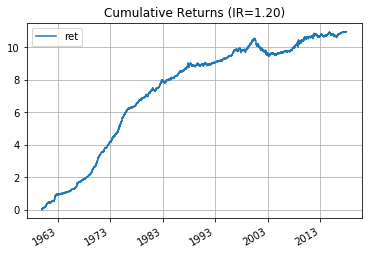

In [21]:
def computeIRFromDaily(daily_rets):
    daily_rets = np.array(daily_rets)
    avgr = np.nanmean(daily_rets)
    stdv = np.nanstd(daily_rets)
    return(np.sqrt(252.)*avgr/stdv)

# compute performance stats
IR = computeIRFromDaily(stra_df['ret'])
IR_str = "IR=%.2f" % IR

# graph the cumulative returns
cumul_df = stra_df.cumsum()
from matplotlib import pyplot as plt
cumul_df.plot(grid=True, title='Cumulative Returns (%s)' % IR_str)

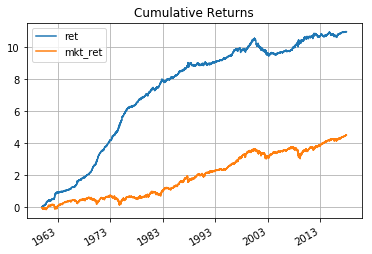

In [11]:
# as a baseline: always long the market over the same period
mrkt_df = mrkt_raw_df.set_index('Date') 
with_base = pd.merge(stra_df, mrkt_df, how='inner', left_index=True, right_index=True)
with_base.rename(columns={'Adj Close':'mkt_ret'}, inplace=True)
with_base_cumul = with_base.cumsum()
from matplotlib import pyplot as plt
with_base_cumul.plot(grid=True, title='Cumulative Returns')

# LSTM Attempt

In [10]:
# Load tensorflow, keras
# This is just using the CPU, no GPU support
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

/Users/marius/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [11]:
len(indu_lagged.columns)

12

In [24]:
# Define the LSTM network architecture
n_predictors = len(indu_lagged.columns)
# LSTM layer architecture:
n_lstm = 5 
drop_lstm = 0.2
# Architecture
model = Sequential()
model.add(LSTM(n_lstm, input_shape=(1, n_predictors), dropout = drop_lstm, return_sequences = True))
model.add(LSTM(n_lstm, input_shape=(1, n_predictors), dropout = drop_lstm, return_sequences = True))
model.add(LSTM(n_lstm, dropout = drop_lstm))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 5)              360       
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 5)              220       
_________________________________________________________________
lstm_6 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 806
Trainable params: 806
Non-trainable params: 0
_________________________________________________________________


In [13]:
def get_x_y(data_df, start, end):
    # returns ndarrays: one for x, one for y
    x = data_df[(data_df.Date >= start) & (data_df.Date < end)] 
    y = x[['Adj Close']]
    y = y.values
    x = x.drop(['Date', 'Adj Close'], axis=1)
    x = x.values
    return x, y


In [19]:
from matplotlib import pyplot
# Use this to fine tune the model between the train and validation sets
# This is mostly used to get the neural network architecture right, before
# we begin the actual backtest. 
def deep_train_validation(deep_model, all_data, 
                           firstTrainDateStr,
                           n_years_train, n_years_test, 
                           n_epochs, batch_size, 
                           verbose = 0):
    
    # Set the intervals for training, testing
    date_line  = all_data['Date']
    train_start_date  = pd.to_datetime(firstTrainDateStr)
    train_end_date = train_start_date + np.timedelta64(365*n_years_train,'D')
    test_start_date = train_end_date
    test_end_date = test_start_date + np.timedelta64(365*n_years_test,'D')

    # Retrieve the data
    x_train, y_train = get_x_y(all_data, train_start_date, train_end_date)
    x_test, y_test   = get_x_y(all_data, test_start_date, test_end_date)
    # Reshape input to be [samples, time steps, features].
    # time steps = 1
    x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))    
    x_test  = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
    
    # When fitting the model, store the history of training, test, 
    # which allows us to display how the loss changes as we train. 
    history = model.fit(x_train, y_train, epochs=n_epochs, batch_size=batch_size, 
                        validation_data=(x_test, y_test), verbose=verbose, shuffle=False)
    # plot history
    pyplot.plot(history.history['loss'],     label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()  

In [20]:
def deep_train_predict(deep_model, all_data, 
                           firstDateStr, lastDateStr,
                           n_years_train, n_years_predict, 
                           n_epochs, batch_size, 
                           verbose = 0):
    # Returns strategy returns 
    # (as data frame indexed by date, with one 'ret' column)

    # Establish the dates over which we invest
    date_line  = all_data['Date']
    firstDate  = pd.to_datetime(firstDateStr)
    lastDate   = pd.to_datetime(lastDateStr)
    strategy_date_line = date_line[(date_line >= firstDate) & (date_line <= lastDate)]
    strategy_date_line = np.array(strategy_date_line)
    
    # Allocate & init the return data frame
    stra_data = {'ret': np.zeros(len(strategy_date_line))}
    stra_df = pd.DataFrame(data=stra_data, index=strategy_date_line)
    
    prior_weight = 0 # remember prior weight
    train_end_date = strategy_date_line[0]
    while train_end_date <= strategy_date_line[-1]:
        print(train_end_date)
        train_start_date = train_end_date - np.timedelta64(365*n_years_train,'D')
        x_train, y_train = get_x_y(all_data, train_start_date, train_end_date)
        # Reshape input to be [samples, time steps, features].
        # time steps = 1
        x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
        model.fit(x_train, y_train, batch_size=batch_size, epochs=n_epochs, verbose=verbose)

        # Once we fit the model on 10 years, keep it same and predict one year (trained on 10 years)
        test_start_date = train_end_date
        test_end_date = min(test_start_date + np.timedelta64(365*n_years_predict, 'D'), strategy_date_line[-1])
        if (test_start_date > test_end_date) or (test_end_date == strategy_date_line[-1]): 
            break
        test_date_line = strategy_date_line[
            (strategy_date_line >= test_start_date) & (strategy_date_line < test_end_date)]
        x_test, y_test = get_x_y(all_data, test_start_date, test_end_date)
        x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
        y_hat = model.predict(x_test)
        for y_idx, y_predicted in enumerate(y_hat):
            y_actual = y_test[y_idx]
            pred_date = test_date_line[y_idx]
            if np.abs(y_predicted) < 1e-10: # do not trade if prediction is close to zero
                weight = prior_weight
            else:
                weight = np.sign(y_predicted)
            stra_df.loc[pred_date] = weight * y_actual

        train_end_date = test_end_date
    return(stra_df)
   

In [21]:
# Ready the data for the backtest
all_data = pd.merge(indu_lagged, mrkt_raw_df, how='inner', on='Date')
all_data.dropna(inplace=True)


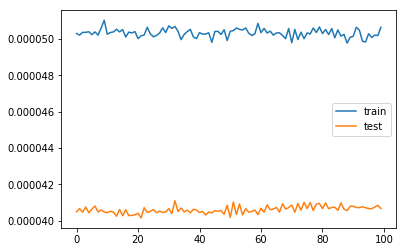

In [32]:
# Finetune the model before the backtest. 
n_train = 10 # train in years
n_test  = 1  # test in years
n_epochs    = 100
batch_size  = 500
deep_train_validation(model, all_data, '1950-01-04',
                           n_train, n_test, 
                           n_epochs, batch_size, 
                           verbose = 0)

# The validation loss may be lower than the train loss, because:
# A. validation uses the model at the end of the epoch, which has lower loss than models at the start of epoch
# B. validation does not use any regularization during training, e.g. no dropouts. 

# We can remove drop-out and see if reason B is dominant. From below, it is not. So A is likely the main reason. 

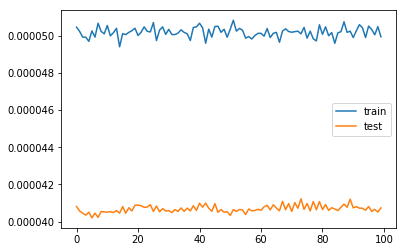

In [33]:
# model with no drop-out, used just for fine-tuning
drop_lstm = 0
model2 = Sequential()
model2.add(LSTM(n_lstm, input_shape=(1, n_predictors), dropout = drop_lstm, return_sequences = True))
model2.add(LSTM(n_lstm, input_shape=(1, n_predictors), dropout = drop_lstm, return_sequences = True))
model2.add(LSTM(n_lstm, dropout = drop_lstm)) # no drop-out - that's the raison d'etre for model2
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])

# Finetune the model before the backtest. 
n_train = 10 # train in years
n_test  = 1  # test in years
n_epochs    = 100
batch_size  = 500
deep_train_validation(model2, all_data, '1950-01-04',
                           n_train, n_test, 
                           n_epochs, batch_size, 
                           verbose = 0)

# There is no change in the loss differences, after we remove regularization (drop-outs).
# So training loss is higher, due to reason A: training includes the bad initial models. 

In [39]:
# Backtest A: medium batch size, few epochs
n_train = 10 # train in years
n_predict  = 1  # test in years
n_epochs    = 100
batch_size  = 500
stra_df = deep_train_predict(model, all_data, 
                           '1960-01-04', '2018-01-01',
                           n_train, n_predict, 
                           n_epochs, batch_size, verbose = 0)
# got IR = 1.24

1960-01-04T00:00:00.000000000
1961-01-03T00:00:00.000000000
1962-01-03T00:00:00.000000000
1963-01-03T00:00:00.000000000
1964-01-03T00:00:00.000000000
1965-01-02T00:00:00.000000000
1966-01-02T00:00:00.000000000
1967-01-02T00:00:00.000000000
1968-01-02T00:00:00.000000000
1969-01-01T00:00:00.000000000
1970-01-01T00:00:00.000000000
1971-01-01T00:00:00.000000000
1972-01-01T00:00:00.000000000
1972-12-31T00:00:00.000000000
1973-12-31T00:00:00.000000000
1974-12-31T00:00:00.000000000
1975-12-31T00:00:00.000000000
1976-12-30T00:00:00.000000000
1977-12-30T00:00:00.000000000
1978-12-30T00:00:00.000000000
1979-12-30T00:00:00.000000000
1980-12-29T00:00:00.000000000
1981-12-29T00:00:00.000000000
1982-12-29T00:00:00.000000000
1983-12-29T00:00:00.000000000
1984-12-28T00:00:00.000000000
1985-12-28T00:00:00.000000000
1986-12-28T00:00:00.000000000
1987-12-28T00:00:00.000000000
1988-12-27T00:00:00.000000000
1989-12-27T00:00:00.000000000
1990-12-27T00:00:00.000000000
1991-12-27T00:00:00.000000000
1992-12-26

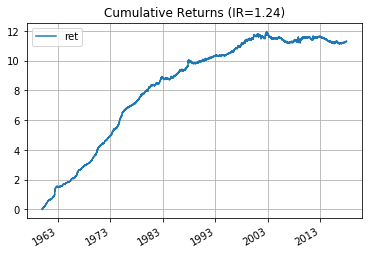

In [40]:
def computeIRFromDaily(daily_rets):
    daily_rets = np.array(daily_rets)
    avgr = np.nanmean(daily_rets)
    stdv = np.nanstd(daily_rets)
    return(np.sqrt(252.)*avgr/stdv)

# compute performance stats
IR = computeIRFromDaily(stra_df['ret'])
IR_str = "IR=%.2f" % IR

# graph the cumulative returns
cumul_df = stra_df.cumsum()
from matplotlib import pyplot as plt
cumul_df.plot(grid=True, title='Cumulative Returns (%s)' % IR_str)

In [42]:
# Backtest B: 0.2 batch size, 5x epochs
n_train     = 10 # train in years
n_predict   = 1  # test in years
n_epochs    = 500
batch_size  = 100 # dmitri: smaller than 100 - no extra value
stra_df = deep_train_predict(model, all_data, 
                           '1960-01-04', '2018-01-01',
                           n_train, n_predict, 
                           n_epochs, batch_size, verbose = 0)
# got IR = 1.24

1960-01-04T00:00:00.000000000
1961-01-03T00:00:00.000000000
1962-01-03T00:00:00.000000000
1963-01-03T00:00:00.000000000
1964-01-03T00:00:00.000000000
1965-01-02T00:00:00.000000000
1966-01-02T00:00:00.000000000
1967-01-02T00:00:00.000000000
1968-01-02T00:00:00.000000000
1969-01-01T00:00:00.000000000
1970-01-01T00:00:00.000000000
1971-01-01T00:00:00.000000000
1972-01-01T00:00:00.000000000
1972-12-31T00:00:00.000000000
1973-12-31T00:00:00.000000000
1974-12-31T00:00:00.000000000
1975-12-31T00:00:00.000000000
1976-12-30T00:00:00.000000000
1977-12-30T00:00:00.000000000
1978-12-30T00:00:00.000000000
1979-12-30T00:00:00.000000000
1980-12-29T00:00:00.000000000
1981-12-29T00:00:00.000000000
1982-12-29T00:00:00.000000000
1983-12-29T00:00:00.000000000
1984-12-28T00:00:00.000000000
1985-12-28T00:00:00.000000000
1986-12-28T00:00:00.000000000
1987-12-28T00:00:00.000000000
1988-12-27T00:00:00.000000000
1989-12-27T00:00:00.000000000
1990-12-27T00:00:00.000000000
1991-12-27T00:00:00.000000000
1992-12-26

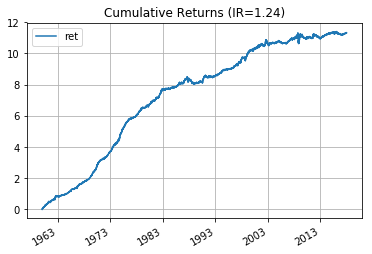

In [43]:
def computeIRFromDaily(daily_rets):
    daily_rets = np.array(daily_rets)
    avgr = np.nanmean(daily_rets)
    stdv = np.nanstd(daily_rets)
    return(np.sqrt(252.)*avgr/stdv)

# compute performance stats
IR = computeIRFromDaily(stra_df['ret'])
IR_str = "IR=%.2f" % IR

# graph the cumulative returns
cumul_df = stra_df.cumsum()
from matplotlib import pyplot as plt
cumul_df.plot(grid=True, title='Cumulative Returns (%s)' % IR_str)